# Part 1: Data Processing

## Import all modules

Make sure to have have downloaded all dependencies available in requirements.txt found in the GitHub repository

In [1]:
# Modules for data processing
from cleantext import clean
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Modules for modelling, evaluation and visualization
import random
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


## Task 1

### Structure, process and clean

In [2]:
# Own function to replace as many date formats as possible
def clean_text(txt):
    # Define regex patterns
    date1 = re.compile(r"\d{4}[-/' ']+\d{2}[-/' ']+\d{2}")  # YYYY-MM-DD or YYYY/MM/DD or YYYY MM DD or a combi (or MM DD in reverse order for all)
    date2 = re.compile(r"\d{2}[-/' ']+\d{2}[-/' ']+\d{4}")  # DD-MM-YYYY or DD/MM/YYYY or DD MM YYYY or a combi (or MM DD in reverse order for all)
    date3 = re.compile(r"(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+(\d{1,2},?\s+\d{4})", re.IGNORECASE)  # MON DD, YYYY or MON DD YYYY
    date4 = re.compile(r"(\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4})", re.IGNORECASE)  # DD MON YYYY
    date5 = re.compile(r"\b([A-Za-z]+ \d{,2},? \d{4})\b") # Month DD, YYYY or Month DD YYYY
    url = re.compile("(https?\:\/\/)?(w*\.?)([\w.-~]+)\.([\w\-~\/]+)(?![\w.-~])")
    number = re.compile("([0-9])+\.?,?([0-9]+)")
    mix = re.compile("\|") # Update as necessary when weird things show up
    numtoken = re.compile("(numtoken){2,}")
    
    # Replace pattern matches
    txt1 = re.sub(date1,"DATE_TOKEN", txt)
    txt2 = re.sub(date2, "DATE_TOKEN", txt1)
    txt3 = re.sub(date3, "DATE_TOKEN", txt2)
    txt4 = re.sub(date4, "DATE_TOKEN", txt3)
    txt5 = re.sub(date5, "DATE_TOKEN", txt4)
    txt6 = re.sub(url, "URL_TOKEN", txt5)
    txt7 = re.sub(number, "NUM_TOKEN", txt6)
    txt8 = re.sub(mix, "MIX_TOKEN", txt7)
    txt9 = re.sub(numtoken,"NUM_TOKEN", txt8)

    return txt9

# cleantext module for e-mails, numbers, currencies, punctutation etc.
def clean_module (text):
    return clean(text,
        fix_unicode=False,               # fix various unicode errors
        to_ascii=False,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_emails=True,                # replace all email addresses with a special token
        no_phone_numbers=True,         # replace all phone numbers with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_digits=True,                # replace all digits with a special token
        no_currency_symbols=False,      # replace all currency symbols with a special token
        no_punct=True,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="URL_TOKEN",
        replace_with_email="EMAIL_TOKEN",
        replace_with_phone_number="NUM_TOKEN",
        replace_with_number="NUM_TOKEN",
        replace_with_digit="NUM_TOKEN",
        replace_with_currency_symbol="CUR_TOKEN",
        lang="en"                       # set to 'de' for German special handling
    )


def clean_text2(txt):
    numtoken = re.compile("(numtoken){2,}")

    txt1 = re.sub(numtoken,"num_token", txt)

    return txt1

# Remove stopwords
my_stopwords = ['datetoken', 'urltoken', 'emailtoken', 'numtoken', 'curtoken', 'mixtoken', 'numtokenth', 'numtokennd','numtokend', '$']
all_stopwords = stopwords.words('english') + my_stopwords

def remove_stopwords (list_of_tokens):
    filtered_list = [w for w in list_of_tokens if w not in all_stopwords]
    return filtered_list

# Perform stemming
stemmer = PorterStemmer()

def stem_words (token_list):
    stemmed_words = [stemmer.stem(i) for i in token_list]
    return stemmed_words

# Get vocabulary
def get_vocabulary_dic (df):
    total_vocab = {}
    for index, row in df.iterrows(): 
        article_vocab = row['content']
        for word in article_vocab:
            if word in total_vocab:
                total_vocab[word] += 1
            else:
                total_vocab[word] = 1
    return total_vocab

# Cleaning pipeline
def clean_text_and_tokenize(content):
    content = clean_text(content)
    content = clean_module(content)
    content = clean_text2(content)
    return word_tokenize(content)

In [3]:
def clean_and_count_vocabulary(df):
    # Clean and tokenize
    df.loc[:,"content"] = df.loc[:,"content"].apply(clean_text_and_tokenize)
    
    # Get vocabulary before stopwords and stemming
    vocab_bf_stopwords_stem = get_vocabulary_dic(df)
    initial_length = len(vocab_bf_stopwords_stem)

    # Remove stopwords
    df.loc[:,"content"] = df.loc[:,"content"].apply(remove_stopwords)

    # Count vocabulary after removing stopwords
    vocab_without_stopwords = get_vocabulary_dic(df)
    length_wo_stopwords = len(vocab_without_stopwords)

    # Perform stemming
    df.loc[:,"content"] = df.loc[:,"content"].apply(stem_words)

    # Count vocabulary after stemming
    vocab_after_stemming = get_vocabulary_dic(df)
    length_after_stemming = len(vocab_after_stemming)

    return initial_length, length_wo_stopwords, length_after_stemming


In [4]:
# Read sample file from url
url = "https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv"
df_sample = pd.read_csv(url)

In [5]:
# Compute vocabulary size and reduction rates
initial_length, length_wo_stopwords, length_after_stemming = clean_and_count_vocabulary(df_sample)
reduction_rate1 = round(((initial_length-length_wo_stopwords)/initial_length)*100,2)
reduction_rate2 = round(((length_wo_stopwords-length_after_stemming)/length_wo_stopwords)*100,2)
print(f"Before any removals the vocabulary had size: {initial_length}. After removing stop words the vocabulary had size: {length_wo_stopwords}, corresponding to a reduction rate of {reduction_rate1}%. After removing word variations that vocabulary had size: {length_after_stemming} corresponding reduction rate of {reduction_rate2}%")

Before any removals the vocabulary had size: 16537. After removing stop words the vocabulary had size: 16395, corresponding to a reduction rate of 0.86%. After removing word variations that vocabulary had size: 10980 corresponding reduction rate of 33.03%


## Task 2 (Exploratory Data Analysis) & Task 3 (Apply preprocessing pipeline to the FakeNewsCorpus)

Make sure to have placed the file containing the 995k Fake News Corpus file in the same respository as this file under the name "995,000_rows.csv"

In [6]:
# Read entire 995k corpus
dataframe_original = pd.read_csv('995,000_rows.csv', low_memory=False)

In [7]:
dataframe = dataframe_original.copy()

In [8]:
# delete weird value of 'type' which looks like a date
i = dataframe[dataframe['type'] == '2018-02-10 13:43:39.521661'].index

dataframe = dataframe.drop(i)

### Frequency of 'missing values' in each column

In [9]:
dataframe.isnull().sum()

Unnamed: 0               0
id                       7
domain                  11
type                 47786
url                     11
content                 12
scraped_at              12
inserted_at             12
updated_at              12
title                 8605
authors             442756
keywords            994999
meta_keywords        38790
meta_description    525105
tags                764080
summary             994999
source              780077
dtype: int64

### Distribution of types

In [10]:
dataframe.type.value_counts()

type
reliable      218564
political     194518
bias          133232
fake          104883
conspiracy     97314
rumor          56445
unknown        43534
unreliable     35332
clickbait      27412
junksci        14040
satire         13160
hate            8779
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='frequency'>

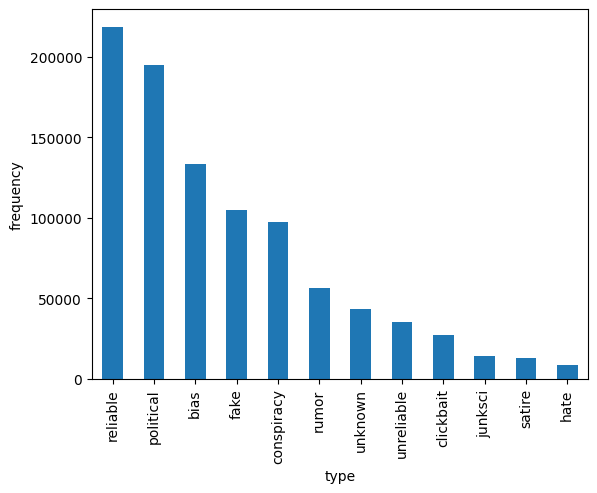

In [11]:
dataframe.type.value_counts().plot.bar(xlabel='type', ylabel='frequency')

### Distribution of domains

In [12]:
dataframe.domain.value_counts(normalize=True).nlargest(10)

domain
nytimes.com           0.177031
beforeitsnews.com     0.091929
dailykos.com          0.078031
express.co.uk         0.056265
nationalreview.com    0.037565
sputniknews.com       0.037417
abovetopsecret.com    0.028088
wikileaks.org         0.023818
www.newsmax.com       0.012752
www.ammoland.com      0.011185
Name: proportion, dtype: float64

<Axes: xlabel='domain', ylabel='relative frequency'>

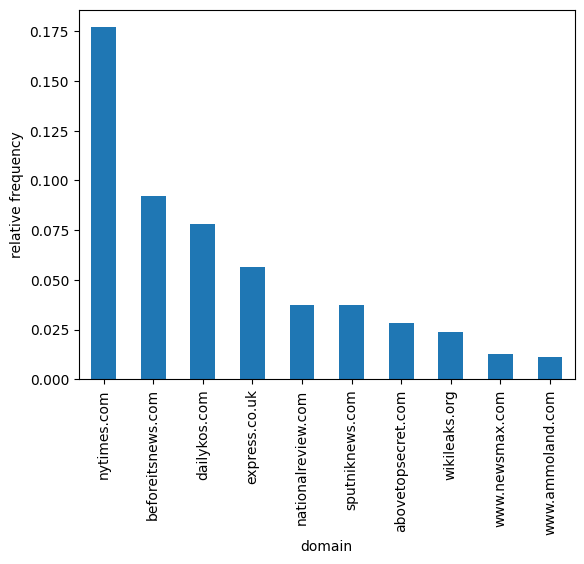

In [13]:
dataframe.domain.value_counts(normalize=True).nlargest(10).plot.bar(xlabel='domain', ylabel='relative frequency')

### What’s the relative frequency of the NYT articles relative to all domains labeled as reliable?

In [14]:
dataframe.loc[dataframe['type']=='reliable', 'domain'].value_counts().nlargest(3)

domain
nytimes.com        176144
www.reuters.com      3956
www.yahoo.com        2629
Name: count, dtype: int64

In [15]:
dataframe.loc[dataframe['type']=='reliable', 'domain'].value_counts(normalize=True).nlargest(3)

domain
nytimes.com        0.805915
www.reuters.com    0.018100
www.yahoo.com      0.012029
Name: proportion, dtype: float64

### What’s the relative frequency of the BIN articles relative to all domains labeled as fake?

In [16]:
dataframe.loc[dataframe['type']=='fake', 'domain'].value_counts().nlargest(3)

domain
beforeitsnews.com           91468
threepercenternation.com     2906
thenet24h.com                2085
Name: count, dtype: int64

In [17]:
dataframe.loc[dataframe['type']=='fake', 'domain'].value_counts(normalize=True).nlargest(3)

domain
beforeitsnews.com           0.872096
threepercenternation.com    0.027707
thenet24h.com               0.019879
Name: proportion, dtype: float64

In [18]:
def analyze_vocabulary(vocab):
    top_100_dic = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:100])
    top_100_words = list(top_100_dic.keys())
    top_10000_dic = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True)[:10000])
    return top_100_words, top_10000_dic

def clean_and_analyze(df):
    # Clean and tokenize
    df.loc[:,"content"] = df.loc[:,"content"].apply(clean_text_and_tokenize)
    
    # Get vocabulary before stopwords and stemming
    vocab_bf_stopwords_stem = get_vocabulary_dic(df)

    # Find most frequent words before removing stop words and stemming
    top_100_words, top_10000_dic = analyze_vocabulary(vocab_bf_stopwords_stem)

    # Find frequency of urls, numbers, and dates
    numbers = (vocab_bf_stopwords_stem["numtoken"] + vocab_bf_stopwords_stem["numtokenth"] + vocab_bf_stopwords_stem["numtokennd"] + vocab_bf_stopwords_stem["numtokend"])
    urls = vocab_bf_stopwords_stem["urltoken"]
    dates = vocab_bf_stopwords_stem["datetoken"]

    # Remove stopwords
    df.loc[:,"content"] = df.loc[:,"content"].apply(remove_stopwords)

    # Perform stemming
    df.loc[:,"content"] = df.loc[:,"content"].apply(stem_words)

    # Analyze vocabulary after stemming
    vocab_after_stemming = get_vocabulary_dic(df)
    top_100_words_v2, top_10000_dic_v2 = analyze_vocabulary(vocab_after_stemming)

    return numbers, urls, dates, top_100_words, top_10000_dic, top_100_words_v2, top_10000_dic_v2

In [19]:
# Remove all types but reliable and fake to ensure reproducability (by avoiding computational issues)
dataframe_v02 = dataframe[dataframe['type'].isin(['fake','reliable'])]

# Remove NaN values to make cleaning function run properly
dataframe_v03 = dataframe_v02.dropna(subset=['content'])  

Beware of the instruction in the README file on how to handle the code below

In [21]:
# Clean, process and analyze entire corpus
numbers, urls, dates, top_100_words, top_10000_dic, top_100_words_v2, top_10000_dic_v2 = clean_and_analyze(dataframe_v03) # Comment out after running the first time

In [22]:
# Download cleaned data to avoid running cleaning and processing on the entire dataset again
dataframe_v03.to_csv('full_dataframe') # Comment out after running the first time
dataframe_v04 = dataframe_v03.copy() # Comment out after running the first time
# dataframe_v04 = pd.read_csv('full_dataframe') # Uncomment and use as dataframe when the run has already run one time. 

In [23]:
print(f"The number of numbers, urls and dates are: numbers: {numbers}, urls: {urls} and dates: {dates}") # Comment out after running the first time

The number of numbers, urls and dates are: numbers: 2261883, urls: 370203 and dates: 74002


In [26]:
dataframe_v04['content'] = dataframe_v04['content'].apply(lambda x: ' '.join(x))  # Comment out after running the first time

## Task 4 (Split dataset into training, validation and test splits)

In [27]:
# pick out articles that are 'fake' and assign to new dataframe
dataframe_f = dataframe_v04[dataframe_v04['type'] == 'fake']

# pick out articles that are 'reliable' and assign to new dataframe
dataframe_r = dataframe_v04[dataframe_v04['type'] == 'reliable']

# sample 100000 from each dataset
dataframe_f = dataframe_f.sample(n = 100000, random_state=42) # 'fake'
dataframe_r = dataframe_r.sample(n = 100000, random_state=42) # 'reliable'

# concatenate the two dataset to form a new balanced dataset
dataframe_v05 = pd.concat([dataframe_f, dataframe_r])

In [28]:
# uniformly split the data 80% / 20% into train and validation/test splits
train, test = train_test_split(dataframe_v05, train_size = 0.8, random_state = 42)

In [29]:
# uniformly split the validation/test data 50% / 50% into validation and test splits
val, test = train_test_split(test, train_size = 0.5, random_state = 42)

# Part 2: Simple model

In [30]:
random.seed(0)

# simple models (baseline models):
def monkey(x):
    return random.choice(['reliable', 'fake'])

def sharp(x):
    return 'fake'

def simple(x):
    match x:
        case 'nytimes.com':
            return 'reliable'
        case 'beforeitsnews.com':
            return 'fake'
        case _:
            return monkey(x)

## Baseline model: monkey

In [31]:
# 'train' monkey and assign its classifications to variable
monkey_y_true = train['type']
monkey_y_pred = train['content'].apply(monkey)

In [32]:
report_monkey = classification_report(monkey_y_true, monkey_y_pred, output_dict = True)

In [33]:
report_monkey['fake']

{'precision': 0.49899227620394826,
 'recall': 0.4982189058457385,
 'f1-score': 0.4986052911376571,
 'support': 80007.0}

In [34]:
report_monkey['reliable']

{'precision': 0.4989078472733627,
 'recall': 0.49968122210693433,
 'f1-score': 0.49929423521329086,
 'support': 79993.0}

## Baseline model: sharp

In [35]:
# 'train' sharp and assign its classifications to variable
sharp_y_true = train['type']
sharp_y_pred = train['content'].apply(sharp)

In [36]:
report_sharp = classification_report(sharp_y_true, sharp_y_pred, output_dict = True)

/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
report_sharp['fake']

{'precision': 0.50004375,
 'recall': 1.0,
 'f1-score': 0.6667055544213294,
 'support': 80007.0}

In [38]:
report_sharp['reliable']

{'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 79993.0}

## Baseline model: simple

In [39]:
# 'train' simple and assign its classifications to variable
simple_y_true = train['type']
simple_y_pred = train['domain'].apply(simple)

In [40]:
report_simple = classification_report(simple_y_true, simple_y_pred, output_dict = True)

In [41]:
report_simple['fake']

{'precision': 0.9065969954278249,
 'recall': 0.936818028422513,
 'f1-score': 0.9214597894038026,
 'support': 80007.0}

In [42]:
report_simple['reliable']

{'precision': 0.9346274215658381,
 'recall': 0.9034665533234157,
 'f1-score': 0.9187828552177423,
 'support': 79993.0}

In [43]:
confusion_simple = confusion_matrix(simple_y_true, simple_y_pred, normalize = 'all')

In [44]:
display = ConfusionMatrixDisplay(confusion_simple)

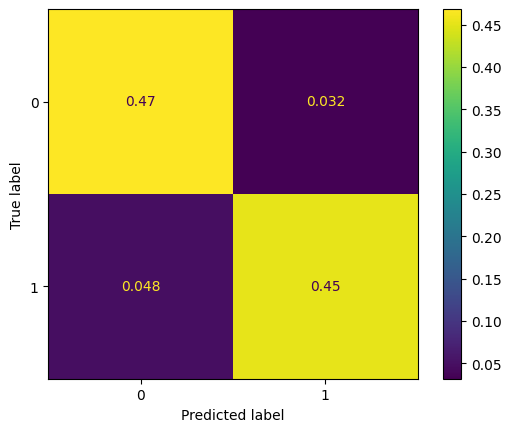

In [45]:
display.plot()

# Part 3: Advanced Model

### Last processing before modelling

In [46]:
# Remove all meta-data to ease computations
train = train.drop(['Unnamed: 0', 'id','domain','url','scraped_at','inserted_at','updated_at','title','authors','keywords','meta_keywords','meta_description','tags','summary','source'],axis=1)
val = val.drop(['Unnamed: 0', 'id','domain','url','scraped_at','inserted_at','updated_at','title','authors','keywords','meta_keywords','meta_description','tags','summary','source'],axis=1)
test = test.drop(['Unnamed: 0', 'id','domain','url','scraped_at','inserted_at','updated_at','title','authors','keywords','meta_keywords','meta_description','tags','summary','source'],axis=1)

In [47]:
# Convert reliable to 0 and fake to 1
train.loc[:, "type"] = train.loc[:, "type"].apply(lambda x: 0 if x=="reliable" else 1)
val.loc[:, "type"] = val.loc[:, "type"].apply(lambda x: 0 if x=="reliable" else 1)
test.loc[:, "type"] = test.loc[:, "type"].apply(lambda x: 0 if x=="reliable" else 1)

In [48]:
# Define x and y values
x_train, y_train = train['content'], train['type']
x_val, y_val = val['content'], val['type']
x_test, y_test = test['content'], test['type']

# Represent text with Tf-idf

In [49]:
# Perform tf-idf on train and validation data
vectorizer = TfidfVectorizer(ngram_range=(1,2))
x_train_vectorized = vectorizer.fit_transform(x_train)
x_val_vectorized = vectorizer.transform(x_val)

In [50]:
# Define type of y-value to avoid issues
y_train = y_train.astype('int64')
y_val = y_val.astype('int64')

## Support Vector Machines

In [51]:
svm_clf = LinearSVC(dual="auto")

svm_parameters = [{
    "C": [0.1, 1, 10] 
}]

svm_grid_search = GridSearchCV(svm_clf, svm_parameters, cv=5, scoring="accuracy", return_train_score=True)

svm_grid_search.fit(x_train_vectorized, y_train)

best_svm = svm_grid_search.best_estimator_

best_svm

LinearSVC(C=10, dual='auto')

In [52]:
svm_acc = best_svm.score(x_val_vectorized,y_val)
print(f"The accuracy of the best performing support vector machines is: {svm_acc}")

The accuracy of the best performing support vector machines is: 0.96705


### Logistic Regression

In [53]:
lr_clf = LogisticRegression()

lr_parameters = [{
    "C": [10]
}]

lr_grid_search = GridSearchCV(lr_clf, lr_parameters, cv=5, scoring="accuracy", return_train_score=True)

lr_grid_search.fit(x_train_vectorized, y_train)

best_lr = lr_grid_search.best_estimator_

best_lr

LogisticRegression(C=10)

In [54]:
lr_acc = best_lr.score(x_val_vectorized,y_val)
print(f"The accuracy of the best performing logistic regression classifer is: {lr_acc}")

The accuracy of the best performing logistic regression classifer is: 0.9589


# Part 4: Evaluation

## Task 1 (Evaluation on FakeNewsCorpus test set)

In [55]:
#Preparation of test data
x_test_vectorized = vectorizer.transform(x_test)
y_test = y_test.astype('int64')

### Evaluation of simple models

In [56]:
# Baseline models
def random_guesser(x):
    return random.choice([0, 1])

def always_1(x):
    return 1

In [57]:
# Make predictions using baseline models
y_pred_random = [random_guesser(x) for x in x_test_vectorized]
y_pred_always_1 = [always_1(x) for x in x_test_vectorized]

# Generate classification reports
report_random = classification_report(y_test, y_pred_random, output_dict=True)
report_always_1 = classification_report(y_test, y_pred_always_1, output_dict=True)

/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [58]:
report_random['1']

{'precision': 0.5042845755280988,
 'recall': 0.5035820895522388,
 'f1-score': 0.503933087722792,
 'support': 10050.0}

In [59]:
report_always_1['1']

{'precision': 0.5025,
 'recall': 1.0,
 'f1-score': 0.6688851913477537,
 'support': 10050.0}

### Evaluation of SVM

In [60]:
svm_y_pred = best_svm.predict(x_test_vectorized)
f1_score(y_test, svm_y_pred)

0.9685384309040223

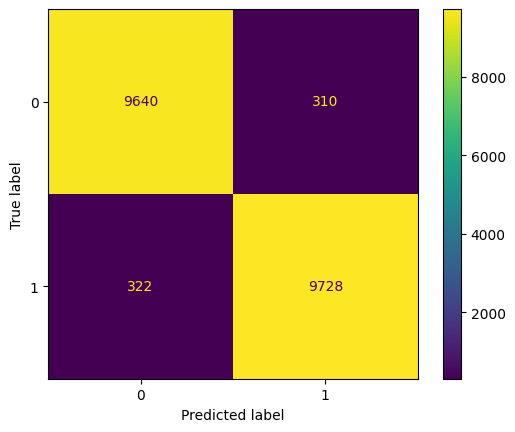

In [61]:
#Confusion matrix for SVM
cm_svm = confusion_matrix(y_test, svm_y_pred, labels=best_svm.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm.classes_)
disp_svm.plot()
plt.savefig('svm_confusion_matrix.png')
plt.show()

In [62]:
# Classification report for SVM
svm_report = classification_report(y_test, svm_y_pred, output_dict = True)
svm_report['1'] # fake

{'precision': 0.9691173540545925,
 'recall': 0.9679601990049751,
 'f1-score': 0.9685384309040223,
 'support': 10050.0}

In [63]:
svm_report['0'] # reliable

{'precision': 0.9676771732583819,
 'recall': 0.9688442211055276,
 'f1-score': 0.9682603455202893,
 'support': 9950.0}

### Evaluation of Logistic Regression

In [64]:
lr_y_pred = best_lr.predict(x_test_vectorized)
f1_score(y_test, lr_y_pred)

0.9588018708329187

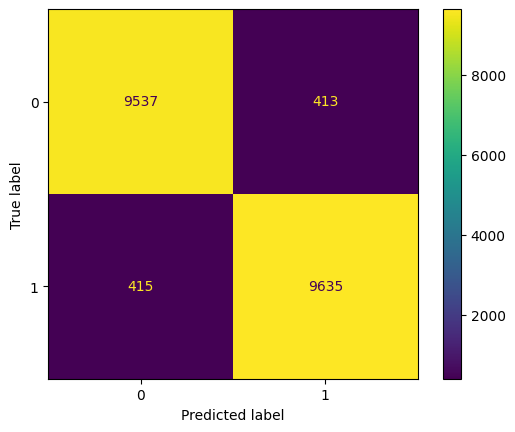

In [65]:
#Confusion matrix for LR
cm_lr = confusion_matrix(y_test, lr_y_pred, labels=best_lr.classes_)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=best_lr.classes_)
disp_lr.plot()
plt.savefig('lr_confusion_matrix.png')
plt.show()

In [66]:
# Classification report for LR
lr_report = classification_report(y_test, lr_y_pred, output_dict = True)
lr_report['1'] # fake

{'precision': 0.9588972929936306,
 'recall': 0.9587064676616915,
 'f1-score': 0.9588018708329187,
 'support': 10050.0}

In [67]:
lr_report['0'] # reliable

{'precision': 0.9582998392282959,
 'recall': 0.9584924623115578,
 'f1-score': 0.9583961410913476,
 'support': 9950.0}

## Task 2 (Evaluation on LIAR test set)

In [68]:
# Read LIAR test set
liar_df = pd.read_csv('test.tsv', sep='\t', names=['id','label','statement','subject','speaker','speakers job','state info', 'party','credit1','credit2','credit3','credit4','credit5','context'])
liar_df.shape

(1267, 14)

In [69]:
# Plot distribution over labels
type_names = ['true','mostly-true','half-true','barely-true','pants-fire','false']

type_counts = {}
for type_name in type_names:
    count = liar_df['label'].value_counts()[type_name]
    type_counts[type_name] = count

count_nan = liar_df["label"].isna().sum()
type_counts['nan'] = count_nan
print(type_counts)

{'true': 208, 'mostly-true': 241, 'half-true': 265, 'barely-true': 212, 'pants-fire': 92, 'false': 249, 'nan': 0}


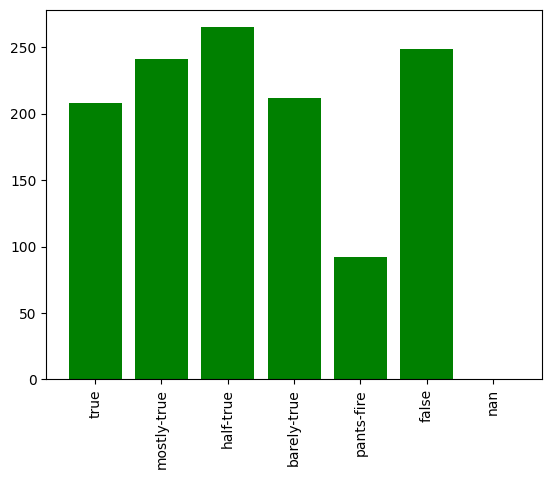

In [70]:
plt.bar(list(type_counts.keys()), type_counts.values(),color='g')
plt.xticks(rotation=90)
plt.show()

In [71]:
#Pre-process
liar_df_v02 = liar_df[liar_df['label'].isin(['true','false'])]
liar_df_v03 = liar_df_v02.drop(['id','subject','speaker','speakers job','state info', 'party','credit1','credit2','credit3','credit4','credit5','context'],axis=1)
liar_df_v03.loc[:, "label"] = liar_df_v03.loc[:, "label"].apply(lambda x: 0 if x=="true" else 1)

In [72]:
# pick out articles that are 'true' and 'false' and assign to new dataframes
dataframe_true = liar_df_v03[liar_df_v03['label'] == 0]
dataframe_false = liar_df_v03[liar_df_v03['label'] == 1]

# sample 200 from each dataset
dataframe_true = dataframe_true.sample(n=200, random_state=42)
dataframe_false = dataframe_false.sample(n=200, random_state=42)

# concatenate the two datasets to form a new balanced dataset
liar_df_v04 = pd.concat([dataframe_true, dataframe_false])

In [73]:
#Tf-idf
x_liar, y_liar = liar_df_v04['statement'], liar_df_v04['label']
x_liar_vectorized = vectorizer.transform(x_liar)

In [74]:
y_liar = y_liar.astype('int64')

### Evaluation of baseline models on LIAR

In [75]:
# Make predictions using baseline models
y_pred_random = [random_guesser(x) for x in x_liar_vectorized]
y_pred_always_1 = [always_1(x) for x in x_liar_vectorized]

# Generate classification reports
report_random_liar = classification_report(y_liar, y_pred_random, output_dict=True)
report_always_1_liar = classification_report(y_liar, y_pred_always_1, output_dict=True)

/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vang/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
report_random_liar['1']

{'precision': 0.54, 'recall': 0.54, 'f1-score': 0.54, 'support': 200.0}

In [77]:
report_always_1_liar['1']

{'precision': 0.5,
 'recall': 1.0,
 'f1-score': 0.6666666666666666,
 'support': 200.0}

### Evaluation of SVM on LIAR

In [78]:
svm_y_liar_pred = best_svm.predict(x_liar_vectorized)
f1_score(y_liar, svm_y_liar_pred)

0.6042884990253411

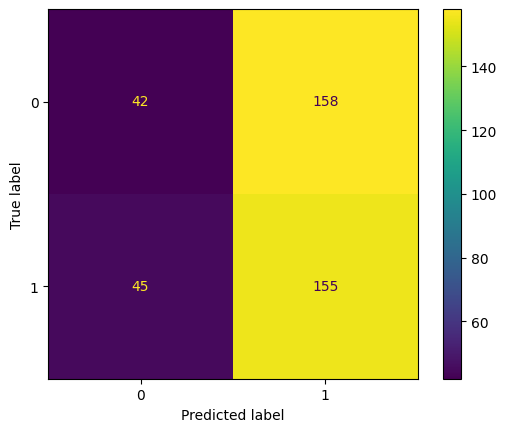

In [79]:
#Confusion matrix for SVM
cm_svm_liar = confusion_matrix(y_liar, svm_y_liar_pred, labels=best_svm.classes_)
disp_svm_liar = ConfusionMatrixDisplay(confusion_matrix=cm_svm_liar, display_labels=best_svm.classes_)
disp_svm_liar.plot()
plt.savefig('svm_confusion_matrix_liar.png')
plt.show()

In [80]:
# Classification report for SVM
svm_report_liar = classification_report(y_liar, svm_y_liar_pred, output_dict = True)
svm_report_liar['1'] # fake

{'precision': 0.4952076677316294,
 'recall': 0.775,
 'f1-score': 0.6042884990253411,
 'support': 200.0}

In [81]:
svm_report_liar['0'] # reliable

{'precision': 0.4827586206896552,
 'recall': 0.21,
 'f1-score': 0.2926829268292683,
 'support': 200.0}

### Evaluation of Logistic Regression on LIAR

In [82]:
lr_y_liar_pred = best_lr.predict(x_liar_vectorized)
f1_score(y_liar, lr_y_liar_pred)

0.6432532347504621

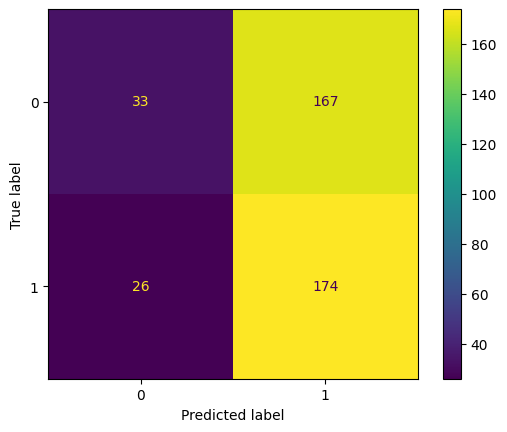

In [83]:
#Confusion matrix for LR
cm_lr_liar = confusion_matrix(y_liar, lr_y_liar_pred, labels=best_lr.classes_)
disp_lr_liar = ConfusionMatrixDisplay(confusion_matrix=cm_lr_liar, display_labels=best_lr.classes_)
disp_lr_liar.plot()
plt.savefig('lr_confusion_matrix_liar.png')
plt.show()

In [84]:
# Classification report for LR
lr_report_liar = classification_report(y_liar, lr_y_liar_pred, output_dict = True)
lr_report_liar['1'] # fake

{'precision': 0.5102639296187683,
 'recall': 0.87,
 'f1-score': 0.6432532347504621,
 'support': 200.0}

In [85]:
lr_report_liar['0'] # reliable

{'precision': 0.559322033898305,
 'recall': 0.165,
 'f1-score': 0.2548262548262548,
 'support': 200.0}